# AoU FHIR & OMOP Analysis
Information about Sync for Science and OMOP patients, and comparing the data of each.

First, define the locations of the data we wish to analyze and compare, and import the necessary modules.

In [1]:
import os
import pandas as pd
import omop_analyze
import fhir_analyze
import aou_analysis

current_directory = os.getcwd()
omop_directory = "\\omop\\20190823"
fhir_directory = "\\fhir\\Participant"

## FHIR Summary
pull in fhir data, let's find some basic data on the number of patients and number of entries retrived

In [2]:
fhir_patients = fhir_analyze.traverse_directory(current_directory+fhir_directory)

got 83 s4s participants


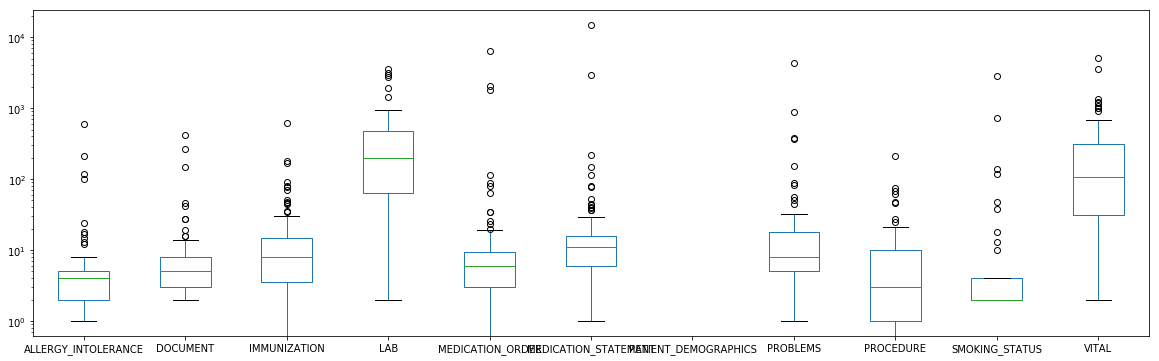

In [8]:
aou_analysis.fhir_plot_category_counts(fhir_patients)

## Common FHIR Values
Most common systems and codings 

In [4]:
aou_analysis.configure_tables()
fhir_systems = aou_analysis.code_system_counts(fhir_patients)
for category, counter in fhir_systems.items():
    df = pd.DataFrame(counter.most_common())
    df.index.name = category
    display(df)

""
PATIENT_DEMOGRAPHICS


,0,1
SMOKING_STATUS,,
0,http://hl7.org/fhir/observation-category,3791
1,None,255


,0,1
PROBLEMS,,
0,http://hl7.org/fhir/condition-category,5447
1,http://loinc.org,1108
2,http://snomed.info/sct,1108
3,http://argonautwiki.hl7.org/extension-codes,1108
4,http://argonaut.hl7.org,856


,0,1
MEDICATION_ORDER,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,5031
1,None,36
2,http://hl7.org/fhir/sid/ndc,5


,0,1
MEDICATION_STATEMENT,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,7737
1,https://apis.followmyhealth.com/fhir/id/translation,23


,0,1
ALLERGY_INTOLERANCE,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,431
1,http://fdasis.nlm.nih.gov,202
2,http://hl7.org/fhir/ndfrt,162
3,http://snomed.info/sct,134
4,http://hl7.org/fhir/sid/ndc,25
5,None,25


,0,1
LAB,,
0,http://hl7.org/fhir/observation-category,35947
1,None,6


,0,1
VITAL,,
0,http://hl7.org/fhir/observation-category,28394
1,None,115


,0,1
PROCEDURE,,
0,http://www.ama-assn.org/go/cpt,268
1,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580,122
2,http://snomed.info/sct,119
3,urn:oid:1.2.840.114350.1.13.362.2.7.2.696580,36
4,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580,28
5,urn:oid:2.16.840.1.113883.6.14,17
6,urn:oid:1.2.840.114350.1.13.71.2.7.2.696580,8
7,None,6


,0,1
IMMUNIZATION,,
0,http://hl7.org/fhir/sid/cvx,1773
1,http://hl7.org/fhir/sid/ndc,272
2,http://www.ama-assn.org/go/cpt,110


,0,1
DOCUMENT,,
0,http://loinc.org,531


In [5]:
fhir_codings = aou_analysis.coding_counts(fhir_patients)
for category, counter in fhir_codings.items():
    df = pd.DataFrame(counter.most_common(20))
    df.index.name = category
    display(df)

""
PATIENT_DEMOGRAPHICS


,0,1
SMOKING_STATUS,,
0,http://hl7.org/fhir/observation-category social-history Social History,3765
1,None None None,255
2,http://hl7.org/fhir/observation-category social-history social-history,26


,0,1
PROBLEMS,,
0,http://hl7.org/fhir/condition-category diagnosis Diagnosis,5447
1,http://loinc.org 29308-4 Diagnosis,1108
2,http://snomed.info/sct 439401001 Diagnosis,1108
3,http://argonautwiki.hl7.org/extension-codes problem Problem,1108
4,http://argonaut.hl7.org problem Problem,856


,0,1
MEDICATION_ORDER,,
0,http://www.nlm.nih.gov/research/umls/rxnorm 308416 Aspir 81 oral delayed release tablet,620
1,http://www.nlm.nih.gov/research/umls/rxnorm 243670 aspirin 81 mg oral tablet,190
2,http://www.nlm.nih.gov/research/umls/rxnorm 3498 Diphenhydramine,140
3,http://www.nlm.nih.gov/research/umls/rxnorm 161 Acetaminophen,135
4,http://www.nlm.nih.gov/research/umls/rxnorm 8640 Prednisone,135
5,http://www.nlm.nih.gov/research/umls/rxnorm 23950 EMLA,130
6,http://www.nlm.nih.gov/research/umls/rxnorm 5224 heparin,120
7,"http://www.nlm.nih.gov/research/umls/rxnorm 318272 aspirin 81 mg oral tablet, chewable",85
8,http://www.nlm.nih.gov/research/umls/rxnorm 259966 Medrol 4 mg oral tablet,80


,0,1
MEDICATION_STATEMENT,,
0,http://www.nlm.nih.gov/research/umls/rxnorm 3498 Diphenhydramine,336
1,http://www.nlm.nih.gov/research/umls/rxnorm 8640 Prednisone,325
2,http://www.nlm.nih.gov/research/umls/rxnorm 161 Acetaminophen,324
3,http://www.nlm.nih.gov/research/umls/rxnorm 23950 EMLA,312
4,http://www.nlm.nih.gov/research/umls/rxnorm 5224 heparin,288
5,http://www.nlm.nih.gov/research/umls/rxnorm 202433 Tylenol,180
6,http://www.nlm.nih.gov/research/umls/rxnorm 203457 Benadryl,168
7,http://www.nlm.nih.gov/research/umls/rxnorm 313782 Acetaminophen 325 MG Oral Tablet,132
8,http://www.nlm.nih.gov/research/umls/rxnorm 10379 Testosterone,108


,0,1
ALLERGY_INTOLERANCE,,
0,http://snomed.info/sct 716186003 No known allergy,44
1,http://www.nlm.nih.gov/research/umls/rxnorm 891658 PEANUT,35
2,http://fdasis.nlm.nih.gov QE1QX6B99R PEANUT,35
3,http://snomed.info/sct 256349002 Peanut - dietary (substance),25
4,http://snomed.info/sct 111088007 Latex (substance),25
5,http://snomed.info/sct 256259004 Pollen (substance),25
6,http://www.nlm.nih.gov/research/umls/rxnorm 2670 Codeine,25
7,http://www.nlm.nih.gov/research/umls/rxnorm 2670 CODEINE,24
8,http://fdasis.nlm.nih.gov Q830PW7520 CODEINE,24


,0,1
LAB,,
0,http://hl7.org/fhir/observation-category laboratory Laboratory,35530
1,http://hl7.org/fhir/observation-category laboratory None,301
2,http://hl7.org/fhir/observation-category laboratory laboratory,106
3,http://hl7.org/fhir/observation-category vital-signs Vital Signs,10
4,None None None,6


,0,1
VITAL,,
0,http://hl7.org/fhir/observation-category vital-signs Vital Signs,28258
1,http://hl7.org/fhir/observation-category vital-signs None,126
2,None None None,115
3,http://hl7.org/fhir/observation-category laboratory Laboratory,10


,0,1
PROCEDURE,,
0,http://www.ama-assn.org/go/cpt 86580 PR TB INTRADERMAL TEST,52
1,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580 10224242 GENERAL PROCEDURE,41
2,"http://snomed.info/sct 90412006 Colonoscope, device (physical object)",25
3,urn:oid:2.16.840.1.113883.6.14 G0121 PR COLON CA SCRN NOT HI RSK IND,17
4,"http://www.ama-assn.org/go/cpt 93351 PR ECHO HEART XTHORACIC, STRESS/REST, W CONTIN ECG",15
5,http://www.ama-assn.org/go/cpt 69210 EAR IRRIGATION,15
6,"http://www.ama-assn.org/go/cpt 93010 ELECTROCARDIOGRAM, ROUTINE W/AT LEAST 12 LEADS",15
7,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580 128454 SPIROMETRY - NURSING,13
8,http://www.ama-assn.org/go/cpt 92133 PR COMPUTERIZED OPHTHALMIC IMAGING OPTIC NERVE,12


,0,1
IMMUNIZATION,,
0,"http://hl7.org/fhir/sid/cvx 140 Influenza, seasonal, injectable, preservative free",112
1,http://hl7.org/fhir/sid/cvx 98 TUBERCULIN PPD TEST,104
2,http://hl7.org/fhir/sid/cvx 115 TDAP,65
3,"http://hl7.org/fhir/sid/cvx 88 INFLUENZA, UNSPECIFIED FORMULATION",58
4,http://hl7.org/fhir/sid/cvx 88 INFLUENZA,51
5,http://hl7.org/fhir/sid/cvx 110 None,50
6,http://hl7.org/fhir/sid/cvx 10 IPV,42
7,http://hl7.org/fhir/sid/ndc 48994 49281-860-10,39
8,http://hl7.org/fhir/sid/cvx 150 INFLUENZA QUADRIVALENT PRESERVATIVE FREE IM,37


,0,1
DOCUMENT,,
0,http://loinc.org 11506-3 Subsequent evaluation note,389
1,http://loinc.org 34133-9 Summarization of Episode Note,142


# OMOP Summary
number of patients and records retrieved from OMOP CSVs

In [6]:
omop_patients, csvs = omop_analyze.parse_omop(path=current_directory+omop_directory)

Got 74 omop participants


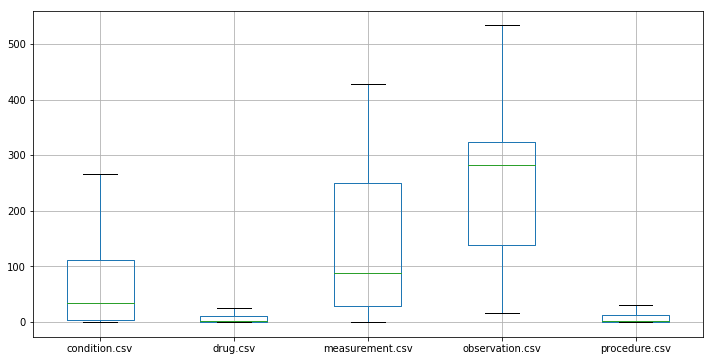

In [7]:
aou_analysis.omop_plot_category_counts(omop_patients, csvs)

# Comparison of OMOP and FHIR data
based on the 